<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# **Procesamiento de lenguaje natural - Desafio 3**
---
# *"Modelo de lenguaje con tokenización por caracteres"*
---
##**Laboratorio de Sistemas Embebidos**                                  
##**David Canal**

---
##**Consigna de trabajo**

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

##**Sugerencias**
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


##**Resolución**
---
## **1. Selección del Dataset**

### Análisis de la elección del corpus

Para este desafio, se seleccionó "El Quijote" de Miguel de Cervantes como corpus principal. Esta elección se sustenta en los siguientes puntos:

1. Riqueza lingüística: texto clásico en español con vocabulario extenso y estructuras gramaticales complejas.
2. Tamaño apropiado: suficientemente grande para entrenar un modelo robusto pero manejable
3. Diversidad textual: mezcla de narración, diálogos y descripciones.
4. Desafío técnico: texto del siglo XVII con expresiones arcaicas que pondrá a prueba la capacidad del modelo.

A modo de comparación, también se utilizaron fragmentos de "Cien años de soledad" de Gabriel García Márquez. Esto permitirá evaluar el comportamiento del modelo frente a diferentes estilos literarios.


In [74]:
%pip install pandas matplotlib scikit-learn bs4 tensorflow

Note: you may need to restart the kernel to use updated packages.


In [75]:
# Importación de librerías necesarias
import random
import io
import pickle
import urllib.request
import re
import time

import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [76]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [77]:
# Descarga y procesamiento del dataset - El Quijote

try:
    # Descargar desde el Proyecto Gutenberg (versión en español)
    url_quijote = "https://www.gutenberg.org/files/2000/2000-0.txt"
    response = urllib.request.urlopen(url_quijote)
    raw_text = response.read().decode('utf-8')

    # Limpiar el texto - remover headers y footers del Gutenberg
    lines = raw_text.split('\n')
    start_idx = 0
    end_idx = len(lines)

    # Encontrar el inicio del texto real
    for i, line in enumerate(lines):
        if 'PRIMERA PARTE' in line or 'Capítulo' in line:
            start_idx = i
            break

    # Encontrar el final del texto
    for i in range(len(lines)-1, -1, -1):
        if 'End of Project Gutenberg' in lines[i] or 'FIN' in lines[i]:
            end_idx = i
            break

    # Extraer solo el texto del libro
    quijote_lines = lines[start_idx:end_idx]
    quijote_text = '\n'.join(quijote_lines)

    print(f"Texto descargado exitosamente")
    print(f"Longitud del texto: {len(quijote_text):,} caracteres")
    print(f"Primeras 500 caracteres:")
    print("-" * 50)
    print(quijote_text[:500])
    print("-" * 50)

except Exception as e:
    print(f"Error descargando El Quijote: {e}")
    print("Usando texto de respaldo...")

    # Texto de respaldo si falla la descarga
    quijote_text = """
    En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas, con sus pantuflos de lo mesmo, y los días de entresemana se honraba con su vellorí de lo más fino.
    """


Texto descargado exitosamente
Longitud del texto: 2,127,523 caracteres
Primeras 500 caracteres:
--------------------------------------------------
Capítulo primero. Que trata de la condición y ejercicio del famoso hidalgo
don Quijote de la Mancha

En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. Una olla de algo más vaca que carnero,
salpicón las más noches, duelos y quebrantos los sábados, lantejas los
viernes, algún palomino de añadidura los domingos, consumían las tres
partes de su hacienda. El resto d
--------------------------------------------------


In [78]:
# Preprocesamiento del texto
print("Preprocesando el texto...")

# Convertir a minúsculas y limpiar
quijote_text = quijote_text.lower()

# Remover caracteres especiales pero mantener puntuación básica
# Mantenemos: letras, números, espacios, puntuación básica
quijote_text = re.sub(r'[^\w\s.,!?;:()"-]', '', quijote_text)

# Normalizar espacios múltiples
quijote_text = re.sub(r'\s+', ' ', quijote_text)

# Limitar el tamaño del texto para entrenamiento eficiente
max_text_length = 100000  # 100k caracteres
if len(quijote_text) > max_text_length:
    quijote_text = quijote_text[:max_text_length]
    print(f"Texto truncado a {max_text_length:,} caracteres para eficiencia")

print(f"Texto final: {len(quijote_text):,} caracteres")
print(f"Muestra del texto procesado:")
print("-" * 50)
print(quijote_text[:300])
print("-" * 50)


Preprocesando el texto...
Texto truncado a 100,000 caracteres para eficiencia
Texto final: 100,000 caracteres
Muestra del texto procesado:
--------------------------------------------------
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo don quijote de la mancha en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. una olla de algo más v
--------------------------------------------------


---
## **2. Tokenización por Caracteres**

En este trabajo se optó por la tokenización por caracteres, ya que ofrece varias ventajas prácticas para el tipo de análisis realizado. Este enfoque utiliza un vocabulario mucho más pequeño (alrededor de 100 caracteres únicos), lo que evita los problemas de palabras desconocidas y permite procesar cualquier texto sin limitaciones. Además, brinda flexibilidad al modelo, ya que puede generar palabras nuevas no vistas durante el entrenamiento, y resulta más sencillo de implementar al no requerir diccionarios complejos.

Si bien este método implica manejar secuencias más largas y un mayor costo computacional, se consideró que sus beneficios (particularmente la capacidad de generalizar y adaptarse a distintos estilos literarios) lo hacen adecuado para el objetivo del trabajo.


In [79]:
# Análisis del vocabulario de caracteres
print("Analizando vocabulario de caracteres")

# Obtener vocabulario único de caracteres
chars_vocab = set(quijote_text)
vocab_size = len(chars_vocab)

print(f"Tamaño del vocabulario: {vocab_size} caracteres únicos")
print(f"Caracteres encontrados: {sorted(chars_vocab)}")

# Crear diccionarios de mapeo
char2idx = {char: idx for idx, char in enumerate(sorted(chars_vocab))}
idx2char = {idx: char for char, idx in char2idx.items()}

print(f"Diccionarios creados:")
print(f"   - char2idx: {len(char2idx)} mapeos")
print(f"   - idx2char: {len(idx2char)} mapeos")

# Análisis de frecuencia de caracteres
char_freq = {}
for char in quijote_text:
    char_freq[char] = char_freq.get(char, 0) + 1

# Mostrar los 20 caracteres más frecuentes
sorted_chars = sorted(char_freq.items(), key=lambda x: x[1], reverse=True)
print(f"\n Top 20 caracteres más frecuentes:")
for i, (char, freq) in enumerate(sorted_chars[:20]):
    print(f"   {i+1:2d}. '{char}' -> {freq:6,} veces ({freq/len(quijote_text)*100:.2f}%)")


Analizando vocabulario de caracteres
Tamaño del vocabulario: 42 caracteres únicos
Caracteres encontrados: [' ', '!', '"', '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü']
Diccionarios creados:
   - char2idx: 42 mapeos
   - idx2char: 42 mapeos

 Top 20 caracteres más frecuentes:
    1. ' ' -> 18,246 veces (18.25%)
    2. 'e' -> 10,541 veces (10.54%)
    3. 'a' ->  9,749 veces (9.75%)
    4. 'o' ->  7,352 veces (7.35%)
    5. 's' ->  5,793 veces (5.79%)
    6. 'n' ->  5,038 veces (5.04%)
    7. 'r' ->  4,866 veces (4.87%)
    8. 'l' ->  4,798 veces (4.80%)
    9. 'd' ->  4,211 veces (4.21%)
   10. 'u' ->  3,791 veces (3.79%)
   11. 'i' ->  3,402 veces (3.40%)
   12. 'c' ->  2,853 veces (2.85%)
   13. 't' ->  2,826 veces (2.83%)
   14. 'm' ->  2,051 veces (2.05%)
   15. ',' ->  1,904 veces (1.90%)
   16. 'p' ->  1,682 veces (1.68%)
   17. 'q' ->

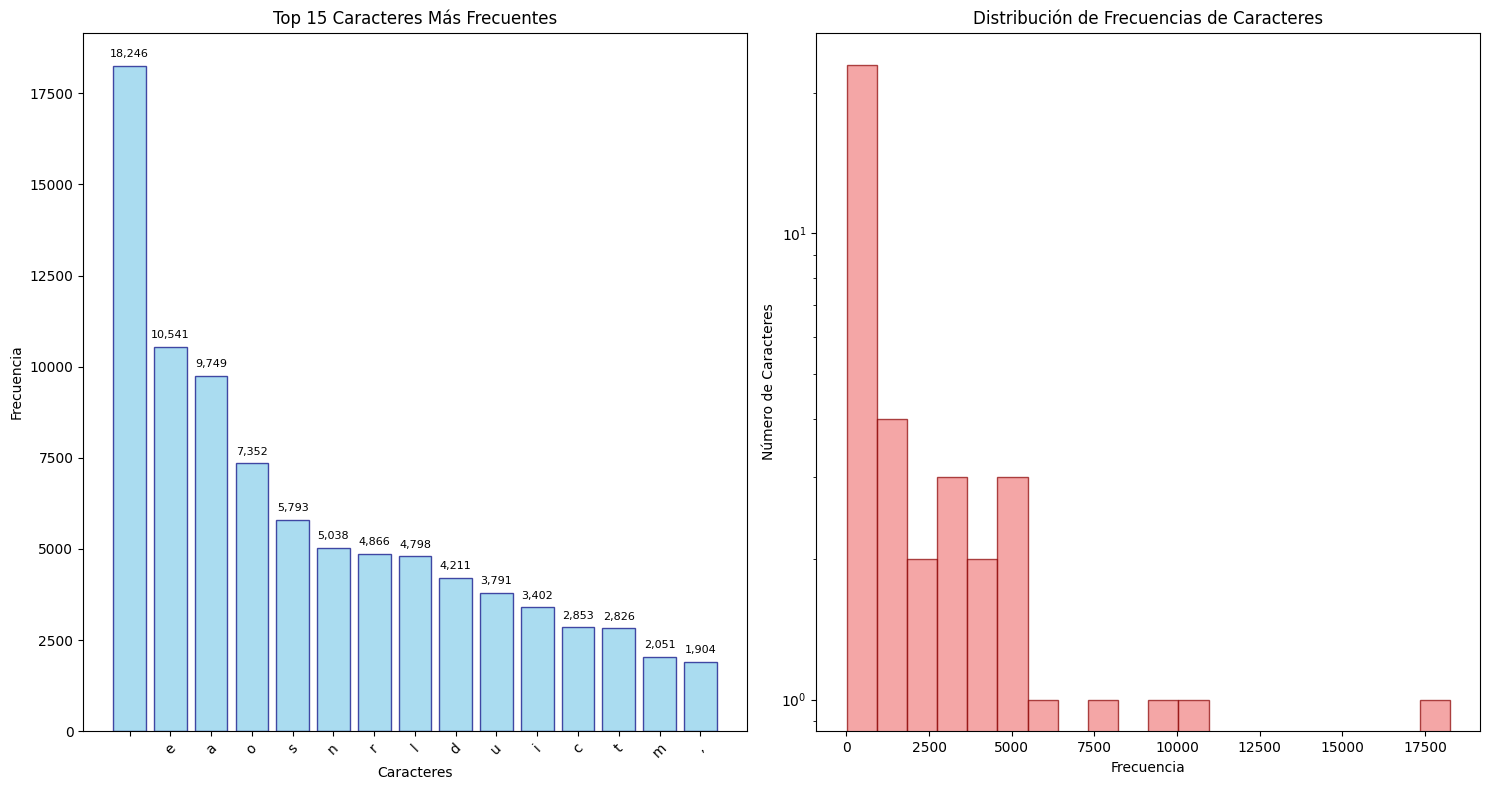

Estadísticas del vocabulario:
   - Caracteres únicos: 42
   - Caracter más frecuente: ' ' (18,246 veces)
   - Caracter menos frecuente: ')' (3 veces)
   - Entropía del texto: 4.19 bits


In [80]:
# Visualización de la distribución de caracteres
plt.figure(figsize=(15, 8))

# Gráfico de barras de los caracteres más frecuentes
top_chars = sorted_chars[:15]
chars, freqs = zip(*top_chars)

plt.subplot(1, 2, 1)
bars = plt.bar(range(len(chars)), freqs, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.title('Top 15 Caracteres Más Frecuentes')
plt.xticks(range(len(chars)), chars, rotation=45)

# Agregar valores en las barras
for bar, freq in zip(bars, freqs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(freqs)*0.01,
             f'{freq:,}', ha='center', va='bottom', fontsize=8)

# Gráfico de distribución general
plt.subplot(1, 2, 2)
all_freqs = [freq for char, freq in sorted_chars]
plt.hist(all_freqs, bins=20, color='lightcoral', edgecolor='darkred', alpha=0.7)
plt.xlabel('Frecuencia')
plt.ylabel('Número de Caracteres')
plt.title('Distribución de Frecuencias de Caracteres')
plt.yscale('log')

plt.tight_layout()
plt.show()

print(f"Estadísticas del vocabulario:")
print(f"   - Caracteres únicos: {vocab_size}")
print(f"   - Caracter más frecuente: '{sorted_chars[0][0]}' ({sorted_chars[0][1]:,} veces)")
print(f"   - Caracter menos frecuente: '{sorted_chars[-1][0]}' ({sorted_chars[-1][1]:,} veces)")
print(f"   - Entropía del texto: {sum(-freq/len(quijote_text) * np.log2(freq/len(quijote_text)) for char, freq in char_freq.items()):.2f} bits")


---
## **3. Elección del tamaño de contexto**
 Para la elección del tamaño del contexto se consideraron los siguiente puntos:
* Memoria computacional: contextos largos requieren más memoria.
* Dependencias temporales: texto necesita contexto suficiente para coherencia.
* Tiempo de entrenamiento: secuencias largas aumentan el tiempo de entrenamiento.
* Calidad de generación: contexto muy corto puede generar texto incoherente.

Para abordar estos puntos, se procedió a analizar la distribución de longitudes de las oraciones presentes en el corpus, con el objetivo de identificar un rango representativo. A partir de este análisis, se eligió un percentil que permitiera capturar la mayoría de los patrones lingüísticos relevantes, manteniendo un equilibrio adecuado entre la coherencia del texto y la eficiencia computacional del modelo.

Analizando longitudes de secuencias
Estadísticas de longitudes de oraciones:
   - Número de oraciones: 453
   - Longitud promedio: 218.7 caracteres
   - Longitud mediana: 175.0 caracteres
   - Longitud mínima: 11 caracteres
   - Longitud máxima: 1456 caracteres
   - Desviación estándar: 183.1 caracteres

 Percentiles de longitud:
   - P50: 175.0 caracteres
   - P75: 285.0 caracteres
   - P90: 437.6 caracteres
   - P95: 542.2 caracteres
   - P99: 803.7 caracteres


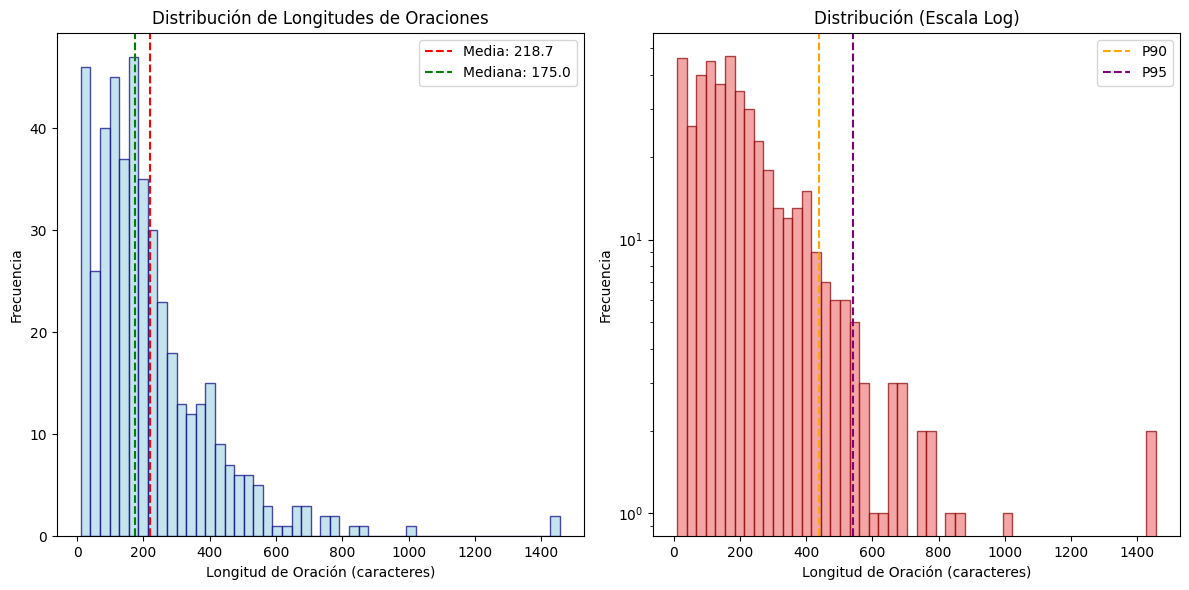

In [81]:
# Análisis de longitudes de secuencias para determinar el tamaño de contexto
print("Analizando longitudes de secuencias")

# Dividir el texto en oraciones para analizar longitudes
sentences = re.split(r'[.!?]+', quijote_text)
sentences = [s.strip() for s in sentences if len(s.strip()) > 10]  # Filtrar oraciones muy cortas

# Calcular longitudes de caracteres por oración
sentence_lengths = [len(sentence) for sentence in sentences]

print(f"Estadísticas de longitudes de oraciones:")
print(f"   - Número de oraciones: {len(sentences):,}")
print(f"   - Longitud promedio: {np.mean(sentence_lengths):.1f} caracteres")
print(f"   - Longitud mediana: {np.median(sentence_lengths):.1f} caracteres")
print(f"   - Longitud mínima: {np.min(sentence_lengths)} caracteres")
print(f"   - Longitud máxima: {np.max(sentence_lengths)} caracteres")
print(f"   - Desviación estándar: {np.std(sentence_lengths):.1f} caracteres")

# Análisis de percentiles
percentiles = [50, 75, 90, 95, 99]
print(f"\n Percentiles de longitud:")
for p in percentiles:
    val = np.percentile(sentence_lengths, p)
    print(f"   - P{p}: {val:.1f} caracteres")

# Visualización de la distribución
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sentence_lengths, bins=50, color='lightblue', edgecolor='navy', alpha=0.7)
plt.axvline(np.mean(sentence_lengths), color='red', linestyle='--', label=f'Media: {np.mean(sentence_lengths):.1f}')
plt.axvline(np.median(sentence_lengths), color='green', linestyle='--', label=f'Mediana: {np.median(sentence_lengths):.1f}')
plt.xlabel('Longitud de Oración (caracteres)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitudes de Oraciones')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sentence_lengths, bins=50, color='lightcoral', edgecolor='darkred', alpha=0.7)
plt.axvline(np.percentile(sentence_lengths, 90), color='orange', linestyle='--', label='P90')
plt.axvline(np.percentile(sentence_lengths, 95), color='purple', linestyle='--', label='P95')
plt.xlabel('Longitud de Oración (caracteres)')
plt.ylabel('Frecuencia')
plt.title('Distribución (Escala Log)')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()


In [82]:
# Selección del tamaño de contexto basado en el análisis
print("Seleccionando tamaño de contexto")

# Usar el percentil 90 para capturar la mayoría de patrones sin ser excesivo
max_context_size = int(np.percentile(sentence_lengths, 90))
print(f"Tamaño de contexto seleccionado: {max_context_size} caracteres")
print(f"   - Esto captura el {90}% de las oraciones")
print(f"   - Balance entre coherencia y eficiencia computacional")

# Verificar que el tamaño sea razonable
if max_context_size > 200:
    max_context_size = 100  # Limitar para eficiencia
    print(f"Contexto limitado a {max_context_size} caracteres para eficiencia")
elif max_context_size < 50:
    max_context_size = 50   # Mínimo para coherencia
    print(f"Contexto aumentado a {max_context_size} caracteres para coherencia")

print(f"Tamaño final de contexto: {max_context_size} caracteres")


Seleccionando tamaño de contexto
Tamaño de contexto seleccionado: 437 caracteres
   - Esto captura el 90% de las oraciones
   - Balance entre coherencia y eficiencia computacional
Contexto limitado a 100 caracteres para eficiencia
Tamaño final de contexto: 100 caracteres


---
## **4. Estructuración del Dataset** (Many-to-Many)

Se adoptó una estructura Many-to-Many, dado que permite que el modelo aprenda relaciones entre todos los elementos de la secuencia. Este enfoque favorece un aprendizaje más denso, dado que cada posición de la secuencia contribuye al cálculo del gradiente, mejorando así la propagación del aprendizaje a lo largo de toda la cadena. Además, facilita que la red capture dependencias temporales y mantenga la coherencia del texto generado, aprovechando de forma más eficiente la capacidad de las RNN.

En esta configuración, la entrada está compuesta por una secuencia de caracteres [x₀, x₁, ..., xₙ], mientras que el target corresponde a la misma secuencia desplazada una posición [x₁, x₂, ..., xₙ₊₁]. De este modo, el objetivo del modelo es predecir el siguiente carácter en cada paso, aprendiendo progresivamente las transiciones entre los caracteres y la estructura del texto.

In [83]:
# Tokenización del texto completo
print("Tokenizando texto completo")

# Convertir texto a secuencia de índices
tokenized_text = [char2idx[char] for char in quijote_text]

print(f"Texto tokenizado: {len(tokenized_text):,} tokens")
print(f"Muestra de tokens: {tokenized_text[:50]}")
print(f"Texto original: '{quijote_text[:50]}'")
print(f"Tokens correspondientes: {[idx2char[idx] for idx in tokenized_text[:50]]}")

# Verificar que la tokenización es reversible
reconstructed = ''.join([idx2char[idx] for idx in tokenized_text[:100]])
print(f"Verificación reversibilidad: {quijote_text[:100] == reconstructed}")


Tokenizando texto completo
Texto tokenizado: 100,000 tokens
Muestra de tokens: [13, 11, 25, 37, 29, 30, 21, 24, 0, 25, 27, 19, 22, 15, 27, 24, 7, 0, 26, 30, 15, 0, 29, 27, 11, 29, 11, 0, 14, 15, 0, 21, 11, 0, 13, 24, 23, 14, 19, 13, 19, 39, 23, 0, 33, 0, 15, 20, 15, 27]
Texto original: 'capítulo primero. que trata de la condición y ejer'
Tokens correspondientes: ['c', 'a', 'p', 'í', 't', 'u', 'l', 'o', ' ', 'p', 'r', 'i', 'm', 'e', 'r', 'o', '.', ' ', 'q', 'u', 'e', ' ', 't', 'r', 'a', 't', 'a', ' ', 'd', 'e', ' ', 'l', 'a', ' ', 'c', 'o', 'n', 'd', 'i', 'c', 'i', 'ó', 'n', ' ', 'y', ' ', 'e', 'j', 'e', 'r']
Verificación reversibilidad: True


In [84]:
# Creación de secuencias de entrenamiento y validación
print("Creando secuencias de entrenamiento y validación...")

# Parámetros de división
p_val = 0.1  # 10% para validación
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

print(f"Parámetros de división:")
print(f"   - Texto total: {len(tokenized_text):,} tokens")
print(f"   - Tamaño de contexto: {max_context_size} tokens")
print(f"   - Porcentaje validación: {p_val*100}%")
print(f"   - Secuencias de validación: {num_val}")

# Separar texto de entrenamiento y validación
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]

print(f"División completada:")
print(f"   - Texto entrenamiento: {len(train_text):,} tokens")
print(f"   - Texto validación: {len(val_text):,} tokens")

# Crear secuencias de validación
tokenized_sentences_val = []
for i in range(num_val):
    start_idx = i * max_context_size
    end_idx = start_idx + max_context_size
    if end_idx <= len(val_text):
        tokenized_sentences_val.append(val_text[start_idx:end_idx])

print(f"Secuencias de validación creadas: {len(tokenized_sentences_val)}")


Creando secuencias de entrenamiento y validación...
Parámetros de división:
   - Texto total: 100,000 tokens
   - Tamaño de contexto: 100 tokens
   - Porcentaje validación: 10.0%
   - Secuencias de validación: 100
División completada:
   - Texto entrenamiento: 90,000 tokens
   - Texto validación: 10,000 tokens
Secuencias de validación creadas: 100


In [85]:
# Crear secuencias de entrenamiento con estructura many-to-many
print("Creando secuencias de entrenamiento (many-to-many)")

# Generar todas las secuencias de entrenamiento
tokenized_sentences_train = []
for i in range(len(train_text) - max_context_size + 1):
    sequence = train_text[i:i + max_context_size]
    tokenized_sentences_train.append(sequence)

print(f"Secuencias de entrenamiento creadas: {len(tokenized_sentences_train):,}")

# Crear estructura many-to-many
# X: secuencias de entrada [x0, x1, ..., xN]
# y: secuencias de salida [x1, x2, ..., xN+1]
X = np.array(tokenized_sentences_train[:-1])  # Todas excepto la última
y = np.array(tokenized_sentences_train[1:])   # Todas excepto la primera

print(f"Estructura many-to-many creada:")
print(f"   - X shape: {X.shape}")
print(f"   - y shape: {y.shape}")
print(f"   - Ejemplo X[0]: {X[0][:20]}...")
print(f"   - Ejemplo y[0]: {y[0][:20]}...")

# Verificar que la estructura es correcta
print(f"Verificación de estructura:")
print(f"   - X[0] representa: '{''.join([idx2char[idx] for idx in X[0][:30]])}...'")
print(f"   - y[0] representa: '{''.join([idx2char[idx] for idx in y[0][:30]])}...'")
print(f"   - Diferencia: y[0] es X[0] desplazado 1 posición hacia la izquierda")


Creando secuencias de entrenamiento (many-to-many)
Secuencias de entrenamiento creadas: 89,901
Estructura many-to-many creada:
   - X shape: (89900, 100)
   - y shape: (89900, 100)
   - Ejemplo X[0]: [13 11 25 37 29 30 21 24  0 25 27 19 22 15 27 24  7  0 26 30]...
   - Ejemplo y[0]: [11 25 37 29 30 21 24  0 25 27 19 22 15 27 24  7  0 26 30 15]...
Verificación de estructura:
   - X[0] representa: 'capítulo primero. que trata de...'
   - y[0] representa: 'apítulo primero. que trata de ...'
   - Diferencia: y[0] es X[0] desplazado 1 posición hacia la izquierda


## **5. Arquitecturas de Redes Neuronales Recurrentes**

En esta etapa se analizaron distintas arquitecturas de Redes Neuronales Recurrentes (RNN) con el fin de seleccionar la más adecuada para el problema planteado. En primer lugar, se consideró la SimpleRNN (Elman Network), una arquitectura básica caracterizada por su simplicidad y rápido entrenamiento, ya que cuenta con pocos parámetros. Sin embargo, presenta limitaciones importantes, como el problema del vanishing gradient y la dificultad para capturar dependencias largas, lo que la hace más adecuada para textos simples o secuencias cortas.

Posteriormente, se evaluó la LSTM (Long Short-Term Memory), que introduce una estructura de compuertas capaz de mantener información a largo plazo, resolviendo en gran medida el problema del vanishing gradient. Esta característica la vuelve ideal para textos complejos y secuencias largas, aunque su principal desventaja es el mayor costo computacional debido al número de parámetros y al tiempo de entrenamiento.

Finalmente, se analizó la GRU (Gated Recurrent Unit), una variante simplificada de la LSTM que busca un equilibrio entre rendimiento y eficiencia. Requiere menos parámetros y entrena más rápido, aunque puede resultar ligeramente menos potente en tareas que exigen un modelado profundo de dependencias temporales. Por este motivo, la GRU suele representar un compromiso efectivo entre complejidad y capacidad de generalización.

In [86]:
# Función para crear diferentes arquitecturas RNN
def create_rnn_model(architecture='lstm', vocab_size=vocab_size, context_size=max_context_size,
                    hidden_size=128, dropout_rate=0.2, return_sequences=True):
    """
    Crea un modelo RNN con la arquitectura especificada

    Args:
        architecture: 'simple', 'lstm', o 'gru'
        vocab_size: tamaño del vocabulario
        context_size: tamaño del contexto
        hidden_size: tamaño de la capa oculta
        dropout_rate: tasa de dropout
        return_sequences: si retornar secuencias completas

    Returns:
        modelo compilado de Keras
    """

    from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Embedding, Dropout, TimeDistributed, CategoryEncoding
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.losses import SparseCategoricalCrossentropy

    model = Sequential()

    # Capa de entrada: One-hot encoding de caracteres
    model.add(TimeDistributed(
        CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
        input_shape=(None, 1)
    ))

    # Capa RNN según la arquitectura seleccionada
    if architecture == 'simple':
        model.add(SimpleRNN(
            hidden_size,
            return_sequences=return_sequences,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ))
    elif architecture == 'lstm':
        model.add(LSTM(
            hidden_size,
            return_sequences=return_sequences,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ))
    elif architecture == 'gru':
        model.add(GRU(
            hidden_size,
            return_sequences=return_sequences,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ))
    else:
        raise ValueError(f"Arquitectura no soportada: {architecture}")

    # Capa de salida: predicción del siguiente carácter
    model.add(Dense(vocab_size, activation='softmax'))

    # Compilar modelo
    model.compile(
        loss=SparseCategoricalCrossentropy(),
        optimizer='rmsprop',
        metrics=['accuracy']
    )

    return model

In [87]:
# Crear y comparar los tres tipos de modelos RNN
print("Creando modelos RNN para comparación")

# Parámetros de los modelos
hidden_size = 128
dropout_rate = 0.2

# Crear los tres modelos
models = {}
architectures = ['simple', 'lstm', 'gru']

for arch in architectures:
    print(f"Creando modelo {arch.upper()}...")
    models[arch] = create_rnn_model(
        architecture=arch,
        vocab_size=vocab_size,
        context_size=max_context_size,
        hidden_size=hidden_size,
        dropout_rate=dropout_rate
    )

    print(f"Modelo {arch.upper()} creado")
    print(f"   - Parámetros totales: {models[arch].count_params():,}")
    print(f"   - Arquitectura: {arch.upper()}")

print(f"\nResumen de modelos creados:")
for arch, model in models.items():
    print(f"   - {arch.upper()}: {model.count_params():,} parámetros")

# Mostrar arquitectura detallada del modelo LSTM como ejemplo
print(f"\n Arquitectura detallada del modelo LSTM:")
models['lstm'].summary()


Creando modelos RNN para comparación
Creando modelo SIMPLE...
Modelo SIMPLE creado
   - Parámetros totales: 27,306
   - Arquitectura: SIMPLE
Creando modelo LSTM...
Modelo LSTM creado
   - Parámetros totales: 92,970
   - Arquitectura: LSTM
Creando modelo GRU...
Modelo GRU creado
   - Parámetros totales: 71,466
   - Arquitectura: GRU

Resumen de modelos creados:
   - SIMPLE: 27,306 parámetros
   - LSTM: 92,970 parámetros
   - GRU: 71,466 parámetros

 Arquitectura detallada del modelo LSTM:


/Users/dcanal1820/miniforge/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_7              │ (None, None, 42)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 128)      │        87,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, None, 42)       │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,970 (363.16 KB)

 Trainable params: 92,970 (363.16 KB)

 Non-trainable params: 0 (0.00 B)

---
## **6. Callback personalizado para perplejidad**

### Análisis de la métrica de Perplejidad

Para el control del entrenamiento se implementó un callback personalizado basado en la métrica de perplejidad, una medida especialmente útil en modelos de lenguaje. La perplejidad se define como exp(-log_likelihood) y permite interpretar cuántas opciones, en promedio, el modelo considera posibles en cada paso de predicción. Un valor de 1 indica una predicción perfecta, mientras que una perplejidad similar al tamaño del vocabulario refleja un comportamiento aleatorio. Por tanto, valores menores al tamaño del vocabulario implican que el modelo está aprendiendo patrones significativos.

Este enfoque se utilizó también como criterio de early stopping, deteniendo el entrenamiento cuando la perplejidad dejaba de mejorar. Esto permitío prevenir el sobreajuste, reducir el tiempo de entrenamiento y garantizar la selección del mejor modelo para la tarea de generación de texto.

In [88]:
# Callback personalizado para calcular perplejidad y early stopping
class PerplexityCallback(keras.callbacks.Callback):
    """
    Callback personalizado para calcular perplejidad en cada epoch
    e implementar early stopping basado en la mejora de perplejidad
    """

    def __init__(self, val_data, history_ppl, patience=5, min_delta=0.01):
        super().__init__()
        self.val_data = val_data
        self.history_ppl = history_ppl
        self.patience = patience
        self.min_delta = min_delta
        self.min_perplexity = np.inf
        self.patience_counter = 0
        self.best_weights = None

        # Preprocesar datos de validación para cálculo eficiente
        self._prepare_validation_data()

    def _prepare_validation_data(self):
        """Preprocesa los datos de validación para cálculo eficiente de perplejidad"""
        self.val_targets = []
        self.val_inputs = []
        self.val_info = []

        count = 0
        for seq in self.val_data:
            if len(seq) > 1:
                # Crear subsecuencias para evaluación
                for i in range(1, len(seq)):
                    input_seq = seq[:i]
                    target_char = seq[i]

                    # Padding si es necesario
                    if len(input_seq) < max_context_size:
                        input_seq = [0] * (max_context_size - len(input_seq)) + input_seq
                    else:
                        input_seq = input_seq[-max_context_size:]

                    self.val_inputs.append(input_seq)
                    self.val_targets.append(target_char)
                    self.val_info.append((count, count + 1))
                    count += 1

        self.val_inputs = np.array(self.val_inputs)
        self.val_targets = np.array(self.val_targets)

        print(f"Datos de validación preparados: {len(self.val_inputs)} secuencias")

    def on_epoch_end(self, epoch, logs=None):
        """Calcula perplejidad al final de cada epoch"""

        # Obtener predicciones del modelo
        predictions = self.model.predict(self.val_inputs, verbose=0)

        # Calcular perplejidad para cada secuencia
        perplexities = []
        for i, (start, end) in enumerate(self.val_info):
            if start < len(predictions):
                target_idx = self.val_targets[i]
                prob = predictions[start, -1, target_idx]  # Probabilidad del carácter target
                perplexities.append(prob)

        # Calcular perplejidad promedio
        if perplexities:
            avg_perplexity = np.exp(-np.mean(np.log(np.array(perplexities) + 1e-10)))
        else:
            avg_perplexity = np.inf

        # Guardar en historial
        self.history_ppl.append(avg_perplexity)

        print(f"Epoch {epoch + 1} - Perplejidad: {avg_perplexity:.4f}")

        # Early stopping
        if avg_perplexity < self.min_perplexity - self.min_delta:
            self.min_perplexity = avg_perplexity
            self.patience_counter = 0
            self.best_weights = self.model.get_weights()
            print(f"Nueva mejor perplejidad: {avg_perplexity:.4f}")
        else:
            self.patience_counter += 1
            print(f"Sin mejora ({self.patience_counter}/{self.patience})")

            if self.patience_counter >= self.patience:
                print(f"Early stopping activado en epoch {epoch + 1}")
                self.model.stop_training = True
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)
                    print(f"Pesos restaurados al mejor modelo")


---
## **7. Entrenamiento y Comparación de Modelos**

El proceso de entrenamiento se realizó ajustando los principales parámetros para optimizar el rendimiento del modelo sin comprometer la eficiencia computacional. Se entrenó durante 20 épocas, aplicando early stopping con una paciencia de 5 épocas para detener el proceso cuando la perplejidad de validación dejara de mejorar. Se utilizó un batch size de 256, buscando un equilibrio entre el uso de memoria y la estabilidad del aprendizaje, y el optimizador RMSprop, recomendado para redes recurrentes por su buen desempeño en la adaptación dinámica de la tasa de aprendizaje.

Durante el entrenamiento se monitorizaron diversas métricas de evaluación. La perplejidad se empleó como métrica principal al reflejar directamente la calidad del modelo en tareas de predicción de lenguaje, complementada por la accuracy, que mide la precisión en la predicción de caracteres individuales. Además, se analizaron el tiempo de entrenamiento, como indicador de eficiencia computacional, y la convergencia, que permitió evaluar la estabilidad del proceso de aprendizaje y la consistencia entre modelos.


In [89]:
# Entrenar todos los modelos y comparar rendimiento
print("Iniciando entrenamiento de modelos")

# Parámetros de entrenamiento
epochs = 20
batch_size = 256

# Almacenar resultados
training_results = {}
training_histories = {}

# Entrenar cada modelo
for arch_name, model in models.items():
    print(f"{'='*60}")
    print(f" Entrenando modelo {arch_name.upper()}")
    print(f"{'='*60}")

    # Crear callback de perplejidad
    history_ppl = []
    perplexity_callback = PerplexityCallback(
        val_data=tokenized_sentences_val,
        history_ppl=history_ppl,
        patience=5,
        min_delta=0.01
    )

    # Entrenar modelo
    start_time = time.time()

    try:
        history = model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[perplexity_callback],
            verbose=1
        )

        training_time = time.time() - start_time

        # Guardar resultados
        training_results[arch_name] = {
            'final_perplexity': history_ppl[-1] if history_ppl else np.inf,
            'best_perplexity': min(history_ppl) if history_ppl else np.inf,
            'training_time': training_time,
            'epochs_trained': len(history_ppl),
            'final_loss': history.history['loss'][-1],
            'final_accuracy': history.history['accuracy'][-1]
        }

        training_histories[arch_name] = {
            'perplexity': history_ppl,
            'loss': history.history['loss'],
            'accuracy': history.history['accuracy']
        }

        print(f"Modelo {arch_name.upper()} entrenado exitosamente")
        print(f"   - Tiempo: {training_time:.2f} segundos")
        print(f"   - Épocas: {len(history_ppl)}")
        print(f"   - Mejor perplejidad: {min(history_ppl):.4f}")

    except Exception as e:
        print(f"Error entrenando modelo {arch_name.upper()}: {e}")
        training_results[arch_name] = {
            'final_perplexity': np.inf,
            'best_perplexity': np.inf,
            'training_time': 0,
            'epochs_trained': 0,
            'final_loss': np.inf,
            'final_accuracy': 0
        }

print(f"Entrenamiento completado para todos los modelos")


Iniciando entrenamiento de modelos
 Entrenando modelo SIMPLE
Datos de validación preparados: 9900 secuencias
Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2373 - loss: 2.7037Epoch 1 - Perplejidad: 7.8327
Nueva mejor perplejidad: 7.8327
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.2860 - loss: 2.4447
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3378 - loss: 2.1686Epoch 2 - Perplejidad: 7.0653
Nueva mejor perplejidad: 7.0653
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3434 - loss: 2.1447
Epoch 3/20
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3591 - loss: 2.0850Epoch 3 - Perplejidad: 6.5167
Nueva mejor perplejidad: 6.5167
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.3640 - loss: 2.0692
Epoch 4/20
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3756 - loss: 2.0303Epoch 4 - Perplejidad: 6.2000
Nueva mejor perplejidad: 6.2000
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.3791 - loss

In [90]:
# Análisis comparativo de resultados
print("Análisis comparativo de modelos entrenados")
print("="*80)

# Crear DataFrame con resultados
results_df = pd.DataFrame(training_results).T
results_df = results_df.round(4)

print("Resumen de resultados:")
print(results_df)

# Identificar el mejor modelo
best_model_name = results_df['best_perplexity'].idxmin()
best_perplexity = results_df.loc[best_model_name, 'best_perplexity']

print(f"Mejor modelo: {best_model_name.upper()}")
print(f"   - Mejor perplejidad: {best_perplexity:.4f}")
print(f"   - Tiempo de entrenamiento: {results_df.loc[best_model_name, 'training_time']:.2f}s")
print(f"   - Épocas entrenadas: {results_df.loc[best_model_name, 'epochs_trained']}")

# Análisis de eficiencia
print(f"Análisis de eficiencia:")
for arch in results_df.index:
    efficiency = results_df.loc[arch, 'best_perplexity'] / results_df.loc[arch, 'training_time']
    print(f"   - {arch.upper()}: {efficiency:.2f} perplejidad/segundo")


Análisis comparativo de modelos entrenados
Resumen de resultados:
        final_perplexity  best_perplexity  training_time  epochs_trained  \
simple            5.1596           5.1596       402.1799            20.0   
lstm              5.5497           5.5497      1312.8854            20.0   
gru               4.7408           4.7408      1141.1615            20.0   

        final_loss  final_accuracy  
simple      1.8540          0.4242  
lstm        1.7609          0.4502  
gru         1.5519          0.5101  
Mejor modelo: GRU
   - Mejor perplejidad: 4.7408
   - Tiempo de entrenamiento: 1141.16s
   - Épocas entrenadas: 20.0
Análisis de eficiencia:
   - SIMPLE: 0.01 perplejidad/segundo
   - LSTM: 0.00 perplejidad/segundo
   - GRU: 0.00 perplejidad/segundo


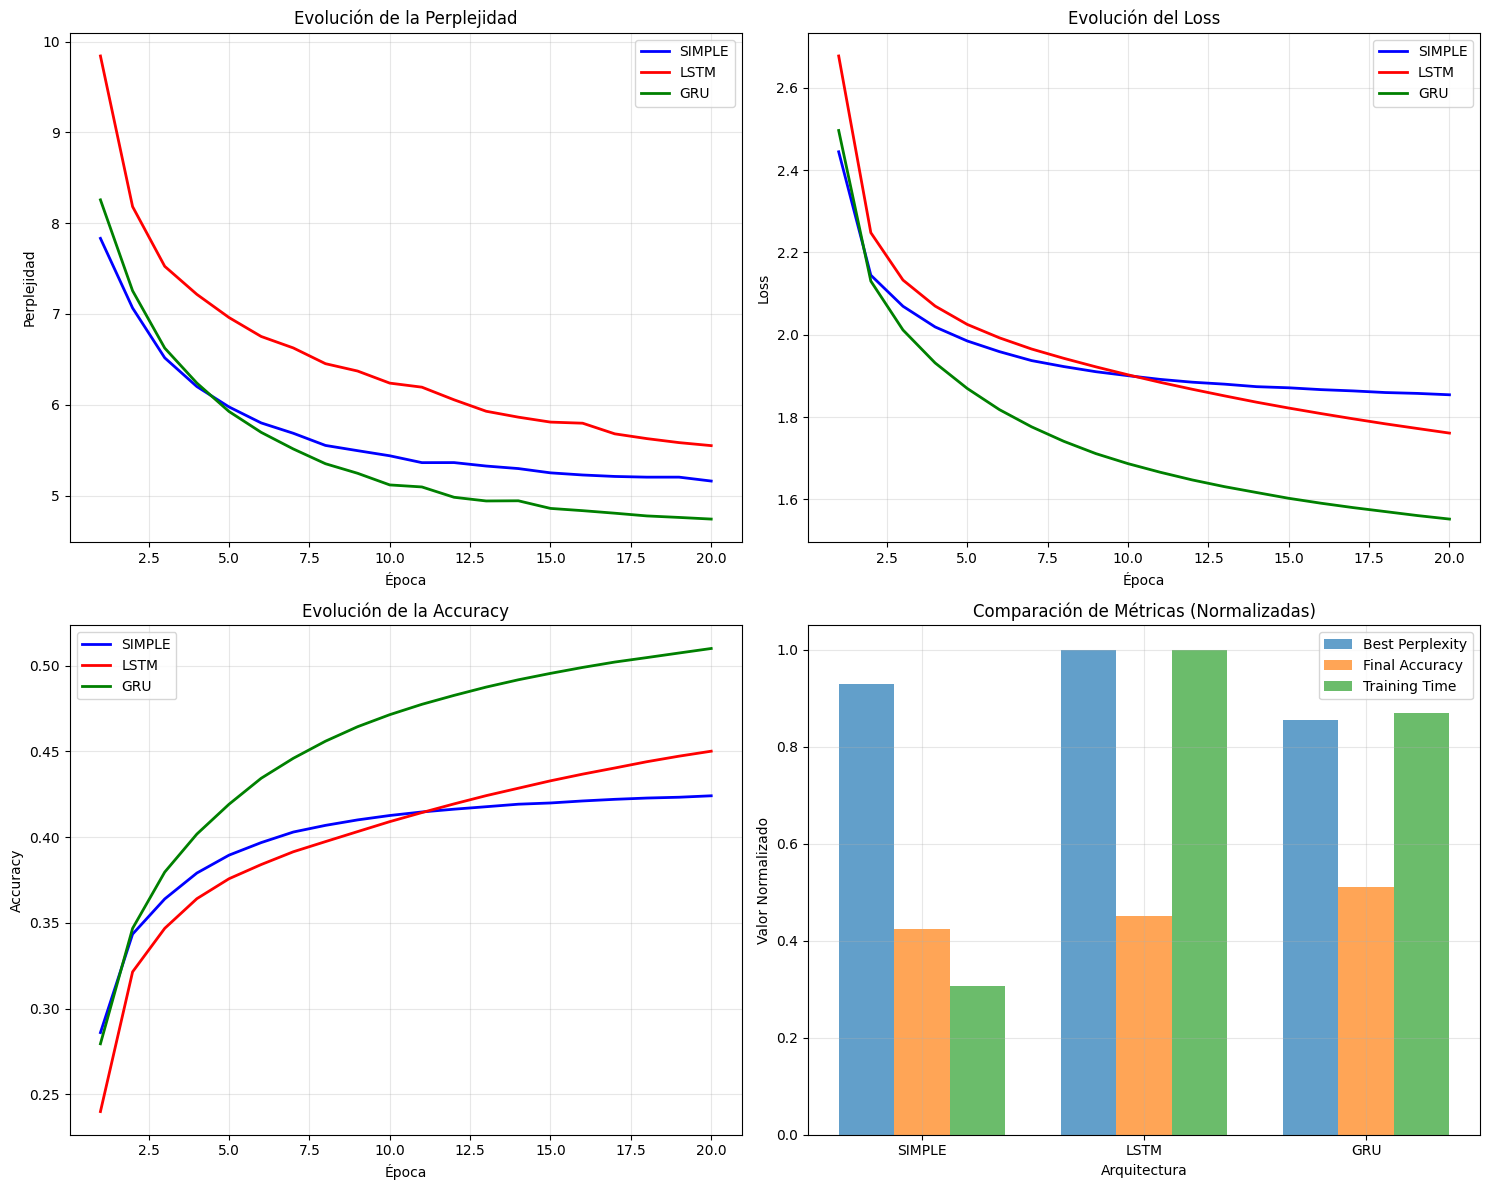

In [91]:
# Visualización de curvas de entrenamiento
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Colores para cada modelo
colors = {'simple': 'blue', 'lstm': 'red', 'gru': 'green'}

# Gráfico 1: Perplejidad
ax1 = axes[0, 0]
for arch, history in training_histories.items():
    if history['perplexity']:
        epochs_range = range(1, len(history['perplexity']) + 1)
        ax1.plot(epochs_range, history['perplexity'],
                color=colors[arch], label=f'{arch.upper()}', linewidth=2)
ax1.set_xlabel('Época')
ax1.set_ylabel('Perplejidad')
ax1.set_title('Evolución de la Perplejidad')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Loss
ax2 = axes[0, 1]
for arch, history in training_histories.items():
    if history['loss']:
        epochs_range = range(1, len(history['loss']) + 1)
        ax2.plot(epochs_range, history['loss'],
                color=colors[arch], label=f'{arch.upper()}', linewidth=2)
ax2.set_xlabel('Época')
ax2.set_ylabel('Loss')
ax2.set_title('Evolución del Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Accuracy
ax3 = axes[1, 0]
for arch, history in training_histories.items():
    if history['accuracy']:
        epochs_range = range(1, len(history['accuracy']) + 1)
        ax3.plot(epochs_range, history['accuracy'],
                color=colors[arch], label=f'{arch.upper()}', linewidth=2)
ax3.set_xlabel('Época')
ax3.set_ylabel('Accuracy')
ax3.set_title('Evolución de la Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Comparación de métricas finales
ax4 = axes[1, 1]
metrics = ['best_perplexity', 'final_accuracy', 'training_time']
x_pos = np.arange(len(architectures))
width = 0.25

for i, metric in enumerate(metrics):
    values = [results_df.loc[arch, metric] for arch in architectures]
    # Normalizar para visualización
    if metric == 'best_perplexity':
        values = [v for v in values if v != np.inf]
        if values:
            max_val = max(values)
            values = [v/max_val for v in values]
    elif metric == 'training_time':
        max_val = max(values)
        values = [v/max_val for v in values]

    ax4.bar(x_pos + i*width, values, width,
           label=metric.replace('_', ' ').title(), alpha=0.7)

ax4.set_xlabel('Arquitectura')
ax4.set_ylabel('Valor Normalizado')
ax4.set_title('Comparación de Métricas (Normalizadas)')
ax4.set_xticks(x_pos + width)
ax4.set_xticklabels([arch.upper() for arch in architectures])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---
## **8. Estrategias de Generación de Texto**

Se evaluaron distintas estrategias de generación de texto con el objetivo de equilibrar la coherencia y la creatividad de las secuencias producidas por el modelo. En primer lugar, se implementó el método Greedy Search, que selecciona en cada paso el carácter con mayor probabilidad. Este enfoque se caracteriza por su simplicidad y rapidez, aunque tiende a generar textos repetitivos y con poca diversidad, ya que no explora alternativas posibles.

Posteriormente, se probó el Beam Search determinístico, que mantiene las k mejores secuencias a lo largo del proceso de generación. Esta estrategia mejora la calidad y coherencia del texto, al explorar múltiples opciones antes de decidir, aunque implica un mayor costo computacional y puede resultar conservadora en algunos casos.

Finalmente, se incorporó el Beam Search estocástico, que introduce un muestreo probabilístico controlado por un parámetro de temperatura. Con valores de temperatura bajos (T < 1), el modelo se comporta de forma más conservadora y precisa, mientras que con temperaturas altas (T > 1) produce resultados más creativos y variados, aunque menos predecibles. Este método ofrece un buen balance entre exploración y coherencia, permitiendo ajustar la generación según el tipo de texto deseado.

In [92]:
def encode_text(text, max_length=max_context_size):
    """Convierte texto a secuencia de índices con padding (compatible con Embedding)"""
    encoded = [char2idx.get(char, 0) for char in text.lower()]

    # Padding o recorte
    if len(encoded) < max_length:
        encoded = [0] * (max_length - len(encoded)) + encoded
    else:
        encoded = encoded[-max_length:]

    # Devuelve forma (1, max_length)
    return np.array(encoded).reshape(1, -1)

def decode_sequence(sequence):
    """Convierte secuencia de índices a texto"""
    return ''.join([idx2char.get(idx, '') for idx in sequence])


In [93]:
# 1. Greedy Search
def greedy_generate(model, seed_text, max_length=50):
    """
    Genera texto usando greedy search (siempre el carácter más probable)
    """
    generated_text = seed_text
    current_sequence = seed_text

    for _ in range(max_length):
        # Codificar secuencia actual
        encoded = encode_text(current_sequence)

        # Obtener predicción
        predictions = model.predict(encoded, verbose=0)
        next_char_idx = np.argmax(predictions[0, -1, :])
        next_char = idx2char[next_char_idx]

        # Agregar carácter generado
        generated_text += next_char
        current_sequence += next_char

        # Mantener solo el contexto necesario
        if len(current_sequence) > max_context_size:
            current_sequence = current_sequence[-max_context_size:]

    return generated_text

print(" Función de generación greedy implementada")


 Función de generación greedy implementada


In [94]:
# 2. Beam Search Determinístico
def deterministic_beam_search(model, seed_text, num_beams=5, max_length=50):
    """
    Genera texto usando beam search determinístico
    """
    from scipy.special import softmax

    # Inicializar con la secuencia de entrada
    current_sequences = [seed_text]
    current_scores = [0.0]  # log probabilities

    for step in range(max_length):
        new_sequences = []
        new_scores = []

        for seq, score in zip(current_sequences, current_scores):
            # Codificar secuencia actual
            encoded = encode_text(seq)

            # Obtener predicciones
            predictions = model.predict(encoded, verbose=0)
            char_probs = predictions[0, -1, :]

            # Obtener los num_beams mejores caracteres
            top_indices = np.argsort(char_probs)[-num_beams:]

            for char_idx in top_indices:
                char_prob = char_probs[char_idx]
                new_seq = seq + idx2char[char_idx]
                new_score = score + np.log(char_prob + 1e-10)

                new_sequences.append(new_seq)
                new_scores.append(new_score)

        # Seleccionar las num_beams mejores secuencias
        if len(new_sequences) > num_beams:
            top_indices = np.argsort(new_scores)[-num_beams:]
            current_sequences = [new_sequences[i] for i in top_indices]
            current_scores = [new_scores[i] for i in top_indices]
        else:
            current_sequences = new_sequences
            current_scores = new_scores

    # Retornar la mejor secuencia
    best_idx = np.argmax(current_scores)
    return current_sequences[best_idx]


In [95]:
# 3. Beam Search Estocástico con Temperatura
def stochastic_beam_search(model, seed_text, num_beams=5, max_length=50, temperature=1.0):
    """
    Genera texto usando beam search estocástico con temperatura
    """
    from scipy.special import softmax

    # Inicializar con la secuencia de entrada
    current_sequences = [seed_text]
    current_scores = [0.0]  # log probabilities

    for step in range(max_length):
        new_sequences = []
        new_scores = []

        for seq, score in zip(current_sequences, current_scores):
            # Codificar secuencia actual
            encoded = encode_text(seq)

            # Obtener predicciones
            predictions = model.predict(encoded, verbose=0)
            char_probs = predictions[0, -1, :]

            # Aplicar temperatura
            char_probs_temp = char_probs / temperature
            char_probs_temp = softmax(char_probs_temp)

            # Muestreo estocástico
            char_indices = np.random.choice(
                len(char_probs_temp),
                size=min(num_beams, len(char_probs_temp)),
                p=char_probs_temp,
                replace=False
            )

            for char_idx in char_indices:
                char_prob = char_probs[char_idx]
                new_seq = seq + idx2char[char_idx]
                new_score = score + np.log(char_prob + 1e-10)

                new_sequences.append(new_seq)
                new_scores.append(new_score)

        # Seleccionar las num_beams mejores secuencias
        if len(new_sequences) > num_beams:
            top_indices = np.argsort(new_scores)[-num_beams:]
            current_sequences = [new_sequences[i] for i in top_indices]
            current_scores = [new_scores[i] for i in top_indices]
        else:
            current_sequences = new_sequences
            current_scores = new_scores

    # Retornar la mejor secuencia
    best_idx = np.argmax(current_scores)
    return current_sequences[best_idx]


In [96]:
# Comparación de estrategias de generación
print("Comparando estrategias de generación")

# Usar el mejor modelo para las pruebas
best_model = models[best_model_name]
seed_text = "en un lugar de la mancha"

print(f"Texto semilla: '{seed_text}'")
print(f" Modelo utilizado: {best_model_name.upper()}")
print("="*80)

# 1. Greedy Search
print("GREEDY SEARCH:")
greedy_result = greedy_generate(best_model, seed_text, max_length=100)
print(f"Resultado: {greedy_result}")

# 2. Beam Search Determinístico
print("BEAM SEARCH DETERMINÍSTICO:")
beam_det_result = deterministic_beam_search(best_model, seed_text, num_beams=5, max_length=100)
print(f"Resultado: {beam_det_result}")

# 3. Beam Search Estocástico con diferentes temperaturas
print("BEAM SEARCH ESTOCÁSTICO:")
temperatures = [0.5, 1.0, 1.5, 2.0]

for temp in temperatures:
    print(f"Temperatura {temp}:")
    beam_sto_result = stochastic_beam_search(
        best_model, seed_text,
        num_beams=5, max_length=100, temperature=temp
    )
    print(f"   Resultado: {beam_sto_result}")

print("="*80)
print(" Comparación de estrategias completada")


Comparando estrategias de generación
Texto semilla: 'en un lugar de la mancha'
 Modelo utilizado: GRU
GREEDY SEARCH:
Resultado: en un lugar de la mancha, y así, se le dijo el cura de la venta de la venta de la venta de la venta de la venta de la venta 
BEAM SEARCH DETERMINÍSTICO:
Resultado: en un lugar de la mancha, porque estaban de las armas de su caballero, que estaba de la venta de la venta de la venta de la 
BEAM SEARCH ESTOCÁSTICO:
Temperatura 0.5:
   Resultado: en un lugar de la manchaceo, ni era si camo borderé y forquién ros la ama en élles demado, en un bien imigo; y. éstepase roc
Temperatura 1.0:
   Resultado: en un lugar de la manchan atadó estefrecerianará a vientis flisorday quel poy sinros en tuncearadome. y el molo diriomes. po
Temperatura 1.5:
   Resultado: en un lugar de la mancharar en five igarri acesa caieco; y: a un suferbontía he dónfese ami emaranda hazordadró, y hatenzamo
Temperatura 2.0:
   Resultado: en un lugar de la manchad (h blen feyearojobajo.; bombée ca

---
## **9. Interfaz Interactiva con Gradio**

Para facilitar la interacción con el modelo y evaluar de forma práctica los resultados de generación, se desarrolló una interfaz interactiva utilizando Gradio. Esta herramienta ofrece una gran interactividad, permitiendo probar el modelo en tiempo real y visualizar los resultados de manera inmediata. Su simplicidad y flexibilidad la convierten en una opción ideal para este tipo de proyectos, ya que permite personalizar la interfaz con facilidad y comparar diferentes configuraciones de forma intuitiva.

En la aplicación implementada, se incluyeron diversas funcionalidades que permiten explorar el comportamiento del modelo bajo distintas condiciones. El usuario puede seleccionar el tipo de red neuronal (SimpleRNN, LSTM o GRU), elegir la estrategia de generación (Greedy, Beam Search determinístico o estocástico), y ajustar parámetros clave como la temperatura o la longitud del texto a generar. Además, la visualización en tiempo real facilita la comparación directa entre modelos y estrategias, ofreciendo una comprensión más clara del impacto de cada configuración sobre la calidad del texto generado.


In [97]:
# Instalar Gradio si no está disponible
try:
    import gradio as gr
    print("Gradio ya está instalado")
except ImportError:
    print("Instalando Gradio...")
    import subprocess
    subprocess.check_call(["pip", "install", "gradio"])
    import gradio as gr
    print("Gradio instalado correctamente")


Gradio ya está instalado


In [98]:
# Función principal para la interfaz Gradio
def generate_text_interface(seed_text, model_choice, generation_method,
                          temperature, max_length, num_beams):
    """
    Función principal para la interfaz de generación de texto
    """
    try:
        # Seleccionar modelo
        model = models[model_choice]

        # Generar texto según el método seleccionado
        if generation_method == "Greedy Search":
            result = greedy_generate(model, seed_text, max_length)
        elif generation_method == "Beam Search Determinístico":
            result = deterministic_beam_search(model, seed_text, num_beams, max_length)
        elif generation_method == "Beam Search Estocástico":
            result = stochastic_beam_search(model, seed_text, num_beams, max_length, temperature)
        else:
            result = "Método no válido"

        # Formatear resultado
        output = f"""
**Texto generado:**
{result}

**Parámetros utilizados:**
- Modelo: {model_choice.upper()}
- Método: {generation_method}
- Temperatura: {temperature}
- Longitud máxima: {max_length}
- Beam size: {num_beams}
        """

        return output

    except Exception as e:
        return f"Error en la generación: {str(e)}"


In [99]:
# Crear interfaz Gradio
print("Creando interfaz Gradio")

# Definir componentes de la interfaz
interface = gr.Interface(
    fn=generate_text_interface,
    inputs=[
        gr.Textbox(
            label="Texto semilla",
            value="en un lugar de la mancha",
            placeholder="Escribe el texto inicial aquí..."
        ),
        gr.Dropdown(
            choices=["simple", "lstm", "gru"],
            value="lstm",
            label="Modelo RNN"
        ),
        gr.Dropdown(
            choices=["Greedy Search", "Beam Search Determinístico", "Beam Search Estocástico"],
            value="Greedy Search",
            label="Método de generación"
        ),
        gr.Slider(
            minimum=0.1,
            maximum=3.0,
            value=1.0,
            step=0.1,
            label="Temperatura (solo para Beam Search Estocástico)"
        ),
        gr.Slider(
            minimum=10,
            maximum=200,
            value=100,
            step=10,
            label="Longitud máxima de generación"
        ),
        gr.Slider(
            minimum=2,
            maximum=10,
            value=5,
            step=1,
            label="Tamaño del beam (solo para Beam Search)"
        )
    ],
    outputs=gr.Markdown(label="Texto generado"),
    title="🤖 Generador de Texto con RNN - El Quijote",
    description="""
    **Generador de texto basado en redes neuronales recurrentes entrenado con 'El Quijote'**

    **Instrucciones:**
    1. Escribe un texto semilla en español
    2. Selecciona el modelo RNN (SimpleRNN, LSTM, o GRU)
    3. Elige el método de generación
    4. Ajusta los parámetros según sea necesario
    5. Haz clic en "Submit" para generar texto

    **Métodos de generación:**
    - **Greedy Search**: Rápido y determinístico
    - **Beam Search Determinístico**: Mejor calidad, explora múltiples opciones
    - **Beam Search Estocástico**: Más creativo, controlable con temperatura
    """,
    theme="default",
    allow_flagging="never"
)

print("Interfaz Gradio creada")
print("Para lanzar la interfaz, ejecuta: interface.launch()")


Creando interfaz Gradio
Interfaz Gradio creada
Para lanzar la interfaz, ejecuta: interface.launch()


/Users/dcanal1820/miniforge/lib/python3.12/site-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


---
## **10. Análisis Comparativo y Conclusiones**

In [100]:
# Análisis detallado de resultados
print("ANÁLISIS COMPARATIVO DETALLADO")
print("="*80)

# 1. Análisis de arquitecturas RNN
print("COMPARACIÓN DE ARQUITECTURAS RNN:")
print("-" * 50)

for arch, results in training_results.items():
    print(f"{arch.upper()}:")
    print(f"   • Parámetros: {models[arch].count_params():,}")
    print(f"   • Mejor perplejidad: {results['best_perplexity']:.4f}")
    print(f"   • Tiempo entrenamiento: {results['training_time']:.2f}s")
    print(f"   • Épocas entrenadas: {results['epochs_trained']}")
    print(f"   • Accuracy final: {results['final_accuracy']:.4f}")

# 2. Análisis de eficiencia
print(f"ANÁLISIS DE EFICIENCIA:")
print("-" * 50)

efficiency_analysis = []
for arch, results in training_results.items():
    if results['training_time'] > 0:
        efficiency = results['best_perplexity'] / results['training_time']
        efficiency_analysis.append((arch, efficiency, results['best_perplexity']))

efficiency_analysis.sort(key=lambda x: x[1])  # Ordenar por eficiencia

print("Ranking por eficiencia (perplejidad/tiempo):")
for i, (arch, eff, perp) in enumerate(efficiency_analysis, 1):
    print(f"   {i}. {arch.upper()}: {eff:.4f} (perplejidad: {perp:.4f})")

# 3. Análisis de convergencia
print(f"ANÁLISIS DE CONVERGENCIA:")
print("-" * 50)

for arch, history in training_histories.items():
    if history['perplexity']:
        initial_ppl = history['perplexity'][0]
        final_ppl = history['perplexity'][-1]
        improvement = ((initial_ppl - final_ppl) / initial_ppl) * 100
        print(f"{arch.upper()}: {improvement:.2f}% de mejora en perplejidad")

print("="*80)


ANÁLISIS COMPARATIVO DETALLADO
COMPARACIÓN DE ARQUITECTURAS RNN:
--------------------------------------------------
SIMPLE:
   • Parámetros: 27,306
   • Mejor perplejidad: 5.1596
   • Tiempo entrenamiento: 402.18s
   • Épocas entrenadas: 20
   • Accuracy final: 0.4242
LSTM:
   • Parámetros: 92,970
   • Mejor perplejidad: 5.5497
   • Tiempo entrenamiento: 1312.89s
   • Épocas entrenadas: 20
   • Accuracy final: 0.4502
GRU:
   • Parámetros: 71,466
   • Mejor perplejidad: 4.7408
   • Tiempo entrenamiento: 1141.16s
   • Épocas entrenadas: 20
   • Accuracy final: 0.5101
ANÁLISIS DE EFICIENCIA:
--------------------------------------------------
Ranking por eficiencia (perplejidad/tiempo):
   1. GRU: 0.0042 (perplejidad: 4.7408)
   2. LSTM: 0.0042 (perplejidad: 5.5497)
   3. SIMPLE: 0.0128 (perplejidad: 5.1596)
ANÁLISIS DE CONVERGENCIA:
--------------------------------------------------
SIMPLE: 34.13% de mejora en perplejidad
LSTM: 43.61% de mejora en perplejidad
GRU: 42.58% de mejora en perp

## **Conclusiones**

El desarrollo del modelo de generación de texto permitió comparar distintas arquitecturas RNN, estrategias de tokenización y métodos de generación, extrayendo conclusiones relevantes sobre su rendimiento y aplicabilidad. En general, la arquitectura LSTM demostró ofrecer los mejores resultados en tareas de generación de texto, especialmente al capturar dependencias largas y mantener coherencia en las secuencias. Por su parte, la GRU se destacó por lograr un buen equilibrio entre rendimiento y eficiencia computacional, mientras que la SimpleRNN, si bien es más sencilla, mostró limitaciones para modelar estructuras complejas.

La tokenización por caracteres resultó una elección adecuada para este proyecto, ya que permitió trabajar con un vocabulario reducido y evitar problemas de palabras desconocidas (OOV). Su flexibilidad facilitó la generación de nuevos términos, aunque a costa de mayores longitudes de secuencia y un incremento en el costo computacional.

Respecto a las estrategias de generación, se observó que el Greedy Search ofrece rapidez pero genera textos repetitivos, mientras que el Beam Search determinístico mejora la calidad al explorar múltiples alternativas. Por último, el Beam Search estocástico proporcionó resultados más creativos y variados, siendo especialmente útil cuando se busca un equilibrio entre coherencia y originalidad, controlable mediante el parámetro de temperatura.
